# Multivariate linear regression

In [4]:
from __future__ import division

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd # used in section 3.1
from scipy import linalg # used in section 3.3
from sklearn.linear_model import LinearRegression # used in the final section of the notebook
from utils import (plot_feature_corr, plot_clusters,
                   plot_pca, plot_feature_importance,
                   pr_curve, print_classfication_report,
                   read_data, write_data, score_model)
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

In [6]:
%matplotlib inline 

In [7]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

# 3 Linear regression with multiple variables

Load the dataset.

In [8]:
data = open('/home/sheraz/git/automatons/automatons/data/data_ex2.csv').readlines()
data = [x.strip().replace("$","").split(' ',0) for x in data]
data = np.array([map(float,x[0].replace(',', '').split()) for x in data])
data.shape

(95, 6)

In [9]:
y = data[:, 0]
data = data[:, 1:] 
data.shape
X1 = data[:,0] * data[:,1]
X2 = data[:,2] / data[:,3]
X3 = data[:,4]
X4 = X1 * X1
X5 = X2 * X2
X6 = X3 * X3
X7 = X1 * X2
X8 = X1 * X3
X9 = X2 * X3
X10 = X1 * X2 * X3
data = np.vstack((X1,X2,X3, X4, X5, X6, X7, X8, X9, X10)).T

M = len(y) 
data.shape

(95, 10)

Visualize 2D projections of the data.

/home/sheraz/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


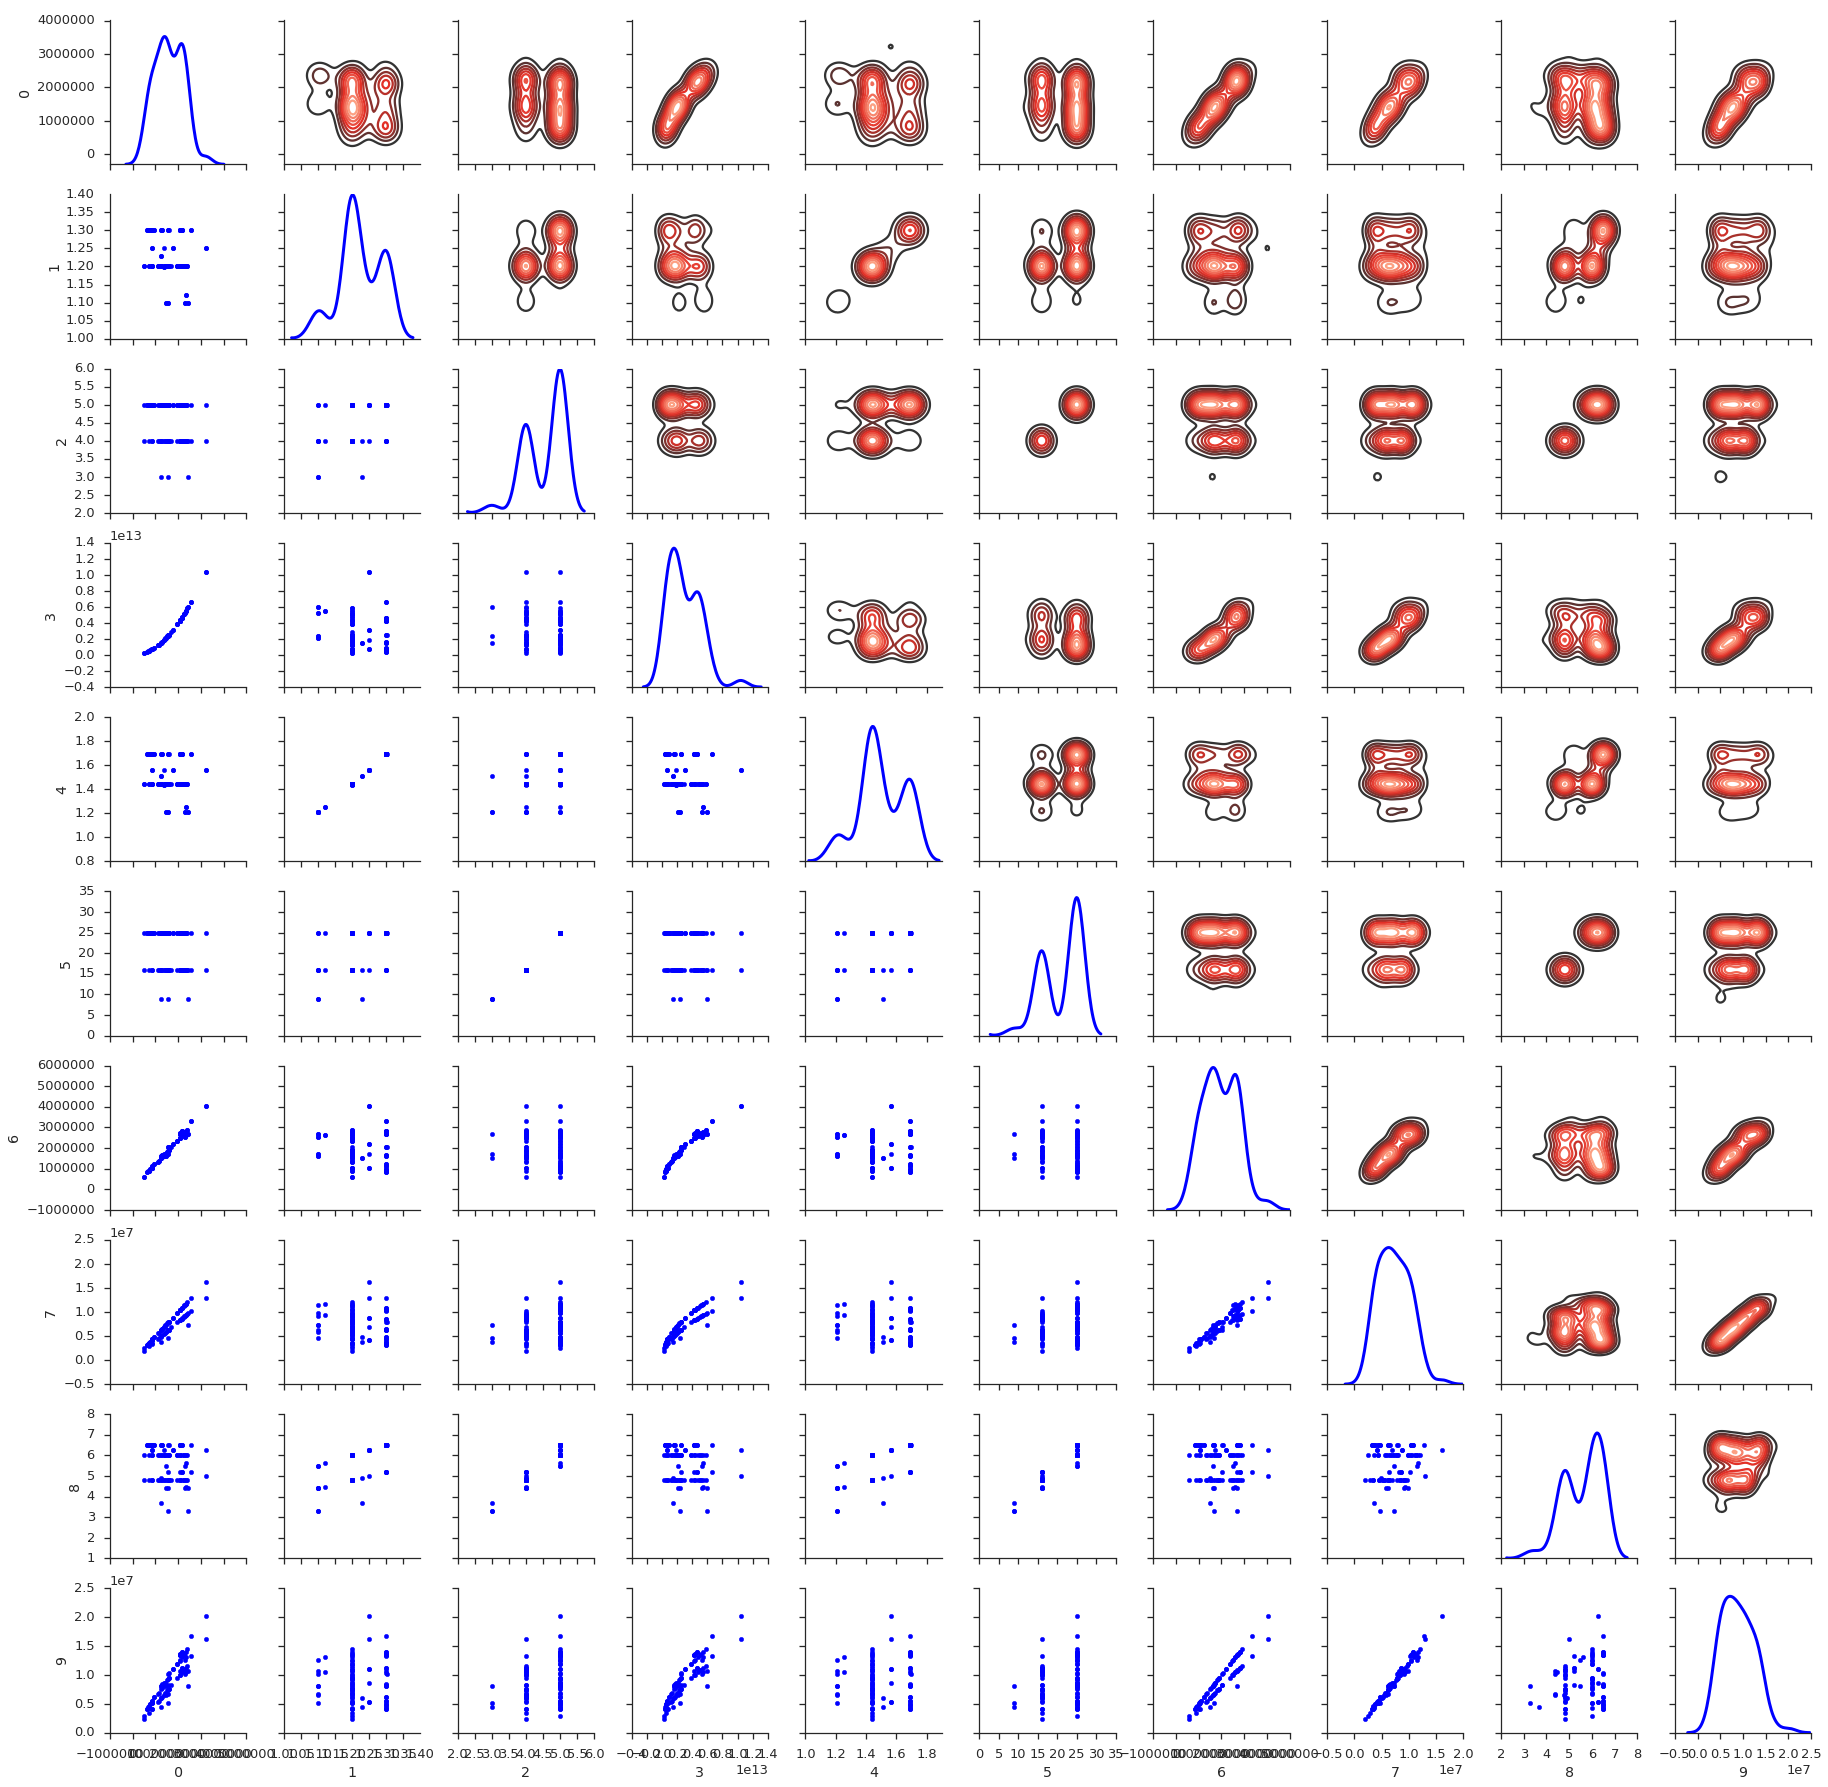

In [10]:
df = pd.DataFrame(data)

g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.kdeplot, cmap="Reds_d")
g.map_lower(plt.scatter)
g.map_diag(sns.kdeplot, lw=3);

## 3.1 Feature normalization

Add a column of ones to the data matrix that allows us to treat the intercept parameter as a feature.

In [11]:
X = np.vstack((np.ones(M), data.T)).T
X.shape

(95, 11)

Define a function returning the normalized data matrix as well as feature means and standard deviations.

In [12]:
def feature_normalize(X):
    """Python version of featureNormalize.m."""
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    
    X_norm_T = np.ones_like(X.T)
    for i, feature in enumerate(X.T):
        if i == 0: continue # skip normalization of the column of ones in X 
        X_norm_T[i] = (feature - mu[i]) / sigma[i]
        
    return X_norm_T.T, mu, sigma

Normalize the features.

In [13]:
X_norm, mu, sigma = feature_normalize(X)
X.shape[1]

11

## 3.2 Gradient descent

Initialize each of the three model parameters to zero. 

In [14]:
theta_0 = np.zeros(X.shape[1])

Define the cost function for multivariate regression.  (It ends up being the same function as for the univariate case due to vectorization.)

In [15]:
def compute_cost(X, y, M, theta):
    """Python version of computeCostMulti.m."""
    return 1 / 2 / M  * np.sum((theta.dot(X.T) - y)**2)

Test it.

In [16]:
print 'Initial cost: %.3e' % compute_cost(X_norm, y, M, theta_0)
X_norm.shape

Initial cost: 1.960e+12


(95, 11)

Define hyperparameters for batch gradient descent.

In [17]:
num_iters = 1000
alpha = 0.1

Implement the gradient descent algorithm. (Again, it ends up being the same function as for the univariate case.)

In [18]:
def gradient_descent(X, y, M, theta_0, alpha, num_iters):
    """Python version of gradientDescentMulti.m."""
    J_history = np.zeros(num_iters)
    theta = theta_0.copy()
    for i in xrange(num_iters):
        J_history[i] = compute_cost(X, y, M, theta)
        theta -= alpha / M * (theta.dot(X.T) - y).dot(X)
        
    return theta, J_history

Test it.

In [19]:
theta, J_history = gradient_descent(X_norm, y, M, theta_0, alpha, num_iters)

In [20]:
print 'Theta found by gradient descent:', ', '.join('%.3f' % item for item in theta)

Theta found by gradient descent: 1916459.674, -48005.812, -33837.950, 48115.175, -162692.040, -42689.975, 221216.557, 31084.906, 197616.228, 17704.495, 278032.108


Plot cost vs. steps.

(0, 2058476756379.4351)

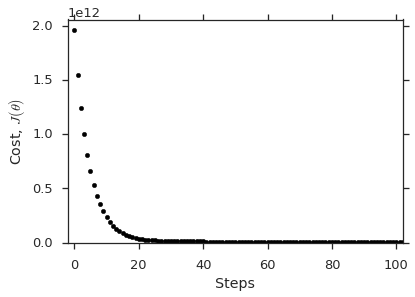

In [21]:
plt.figure()
plt.scatter(np.arange(num_iters), J_history, c='k', marker='o')
plt.xlabel('Steps')
plt.ylabel('Cost, ' + r'$J(\theta)$')
plt.xlim(-num_iters / 10 * 0.02, num_iters / 10 * 1.02)
plt.ylim(0, max(J_history) * 1.05)

Plot cost vs. steps for multiple choices of the learning rate, alpha.

In [22]:
_, J_history_1 = gradient_descent(X_norm, y, M, theta_0, 0.01, num_iters)
_, J_history_2 = gradient_descent(X_norm, y, M, theta_0, 0.03, num_iters)
_, J_history_3 = gradient_descent(X_norm, y, M, theta_0, 0.30, num_iters)

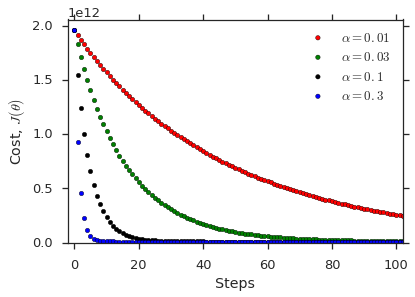

In [23]:
plt.figure()
plt.scatter(np.arange(num_iters), J_history_1, c='r', marker='o', label=r'$\alpha=0.01$')
plt.scatter(np.arange(num_iters), J_history_2, c='g', marker='o', label=r'$\alpha=0.03$')
plt.scatter(np.arange(num_iters), J_history, c='k', marker='o', label=r'$\alpha=0.1$')
plt.scatter(np.arange(num_iters), J_history_3, c='b', marker='o', label=r'$\alpha=0.3$')
plt.xlabel('Steps')
plt.ylabel('Cost, ' + r'$J(\theta)$')
plt.xlim(-num_iters / 10 * 0.02, num_iters / 10 * 1.02)
plt.ylim(0, max(J_history) * 1.05)
plt.legend(numpoints=1, loc=0)

Define a function that returns the model prediction for price.

In [24]:
def prediction(theta, x0, x1, mu, sigma):
    return theta[0] + (x0 - mu[1]) / sigma[1] * theta[1] + (x1 - mu[2]) / sigma[2] * theta[2]

Compare training data with linear regression predictions.

## 3.3 Normal equations

Define a function to compute the analytical solution to linear regression.

In [25]:
def normal_eqn(X, y):
    return linalg.inv(X.T.dot(X)).dot(X.T).dot(y).T

Test it.

In [26]:
theta_from_normal_eqn = normal_eqn(X_norm, y)

In [27]:
print 'Best fit parameters obtained from gradient descent:', \
    ', '.join('%.3f' % item for item in theta)
print 'Best fit parameters obtained from the normal equations:', \
    ', '.join('%.3f' % item for item in theta_from_normal_eqn)
    
X.shape

Best fit parameters obtained from gradient descent: 1916459.674, -48005.812, -33837.950, 48115.175, -162692.040, -42689.975, 221216.557, 31084.906, 197616.228, 17704.495, 278032.108
Best fit parameters obtained from the normal equations: 1916459.674, 3476993.533, 356232.108, 1254613.119, -118500.512, 244445.376, 702174.451, -3626010.950, -3627156.361, -2052893.147, 4237391.732


(95, 11)

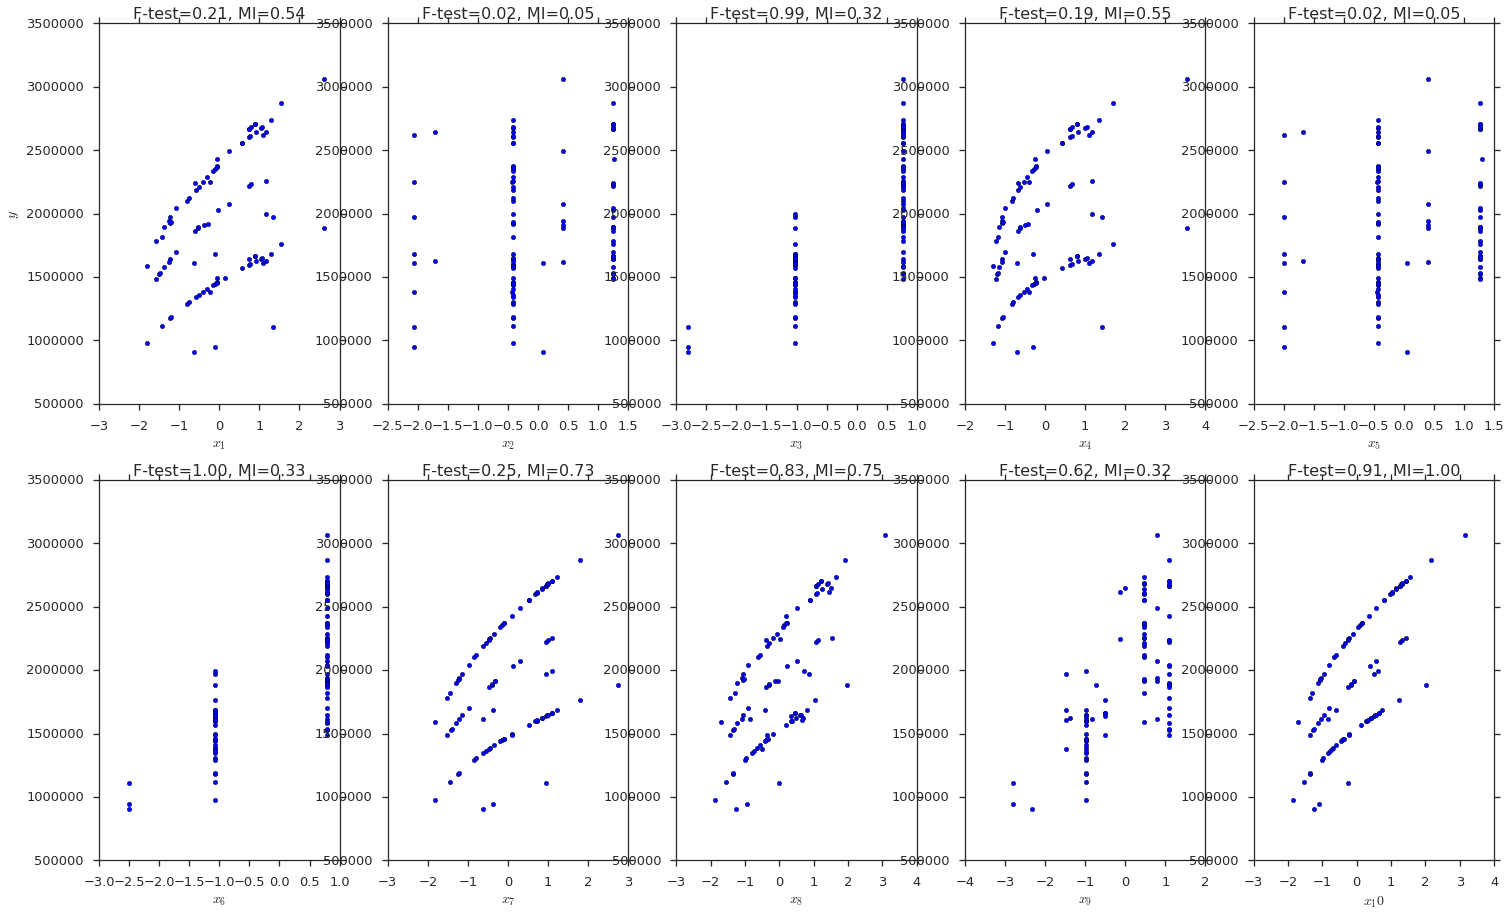

In [55]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_norm[:,1:], y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X_norm[:,1:], y)
mi /= np.max(mi)

plt.figure(figsize=(25, 15))
for i in range(X_norm.shape[1]-1):
    plt.subplot(2, X_norm.shape[1]/2, i + 1)
    plt.scatter(X_norm[:, i+1], y, edgecolor='black', s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
plt.show()

In [80]:
cost_history = []

def lin_reg_cost_function(theta, X, y, lam):
    """Python version of linearRegCostFunction.m."""

    cost = 1 / 2 / M * np.sum((theta.dot(X.T) - y)**2) + lam / 2 / M * np.sum(theta[1:]**2)
    
    cost_history.append(cost)
    return cost

In [81]:
lam = 1
lin_theta_0 = np.ones(X.shape[1])

cost = lin_reg_cost_function(lin_theta_0, X_norm, y, lam)

print 'Cost at theta = [1, 1]: %.3f' % cost

Cost at theta = [1, 1]: 1960449517766.094


In [82]:
cost_history = []

def lin_reg_cost_function(theta, X, y, lam):
    """Python version of linearRegCostFunction.m after completing 'Part 3' of ex5.m."""
    
    cost = 1 / 2 / M * np.sum((theta.dot(X.T) - y)**2) + lam / 2 / M * np.sum(theta[1:]**2)
    
    grad = 1 / M * (theta.dot(X.T) - y).dot(X) + lam / M * np.array([0 if i == 0 else theta[i] for i in xrange(len(theta))])

    cost_history.append(cost)
    return cost, grad

In [83]:
lam = 1
lin_theta_0 = np.ones(X_norm.shape[1])

cost, grad = lin_reg_cost_function(lin_theta_0, X_norm, y, lam)

print 'Gradient at theta = [1, 1]: [%.6f, %.6f]' % (grad[0], grad[1])

Gradient at theta = [1, 1]: [-1916458.673684, -225784.073899]


In [84]:
lam = 0
cost_history = []
def train_linear_reg(lin_theta_0, X, y, lam):
    res = minimize(lin_reg_cost_function, lin_theta_0, method='L-BFGS-B', args=(X, y, lam), jac=True) 
    return res

In [96]:
lin_theta_0 = np.ones(X_norm.shape[1])

res = train_linear_reg(lin_theta_0, X_norm, y, lam)

theta = res['x']
print res

      fun: 8340611077.3586617
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.17145418, -0.95302431, -0.62137403, -0.53898891, -0.34234707,
       -0.49995235, -0.11979757, -0.94179899, -0.87279269, -0.52743576,
       -0.78224319])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 407
      nit: 367
   status: 0
  success: True
        x: array([ 1916459.84513839,  3477401.83780659,   356103.51302411,
        1254735.81809102,  -118479.37552559,   244656.49556982,
         702275.29241798, -3626470.40954698, -3627681.22203689,
       -2053173.6702291 ,  4237951.42338104])


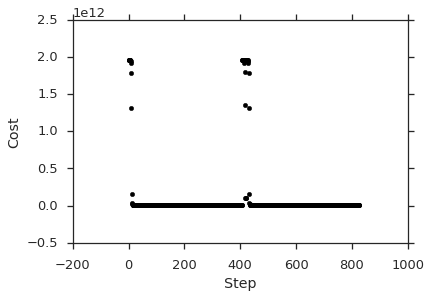

In [97]:
num_steps = len(cost_history)

plt.figure()
plt.scatter(np.arange(num_steps), cost_history, c='k', marker='o')
plt.xlabel('Step')
plt.ylabel('Cost')

In [98]:
def add_column_ones(x):
    if np.isscalar(x):
        x = np.array((1, x))
    else:
        x = np.vstack((np.ones((x.shape[0],)), x)).T
    return x

def prediction(theta, x, mu = 0, sigma = 1):
    theta = theta.reshape((len(theta), 1))
    x = (x - mu) / sigma
    x = add_column_ones(x)
    pred = np.dot(x, theta)
    return pred

()


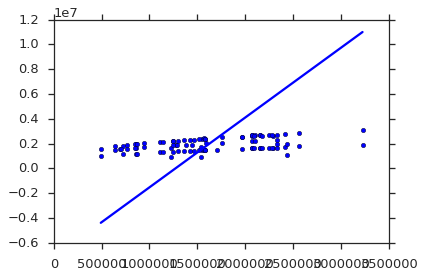

In [99]:
plt.figure()
plt.scatter(X[:,1], y)
x_pts = np.linspace(X[:,1].min(), X[:,1].max(), 100)
plt.plot(x_pts, prediction(theta[:2], x_pts, mu[1], sigma[1]), 'b-', label='Linear regression')
print()


In [102]:
def learning_curve(lin_theta_0, X, y, X_val, y_val, lam):
    error_train, error_val = np.zeros(M-1), np.zeros(M-1)
    for i in xrange(2, M+1):
        res_train = train_linear_reg(lin_theta_0, X[:, :i], y[:i], lam)
        theta = res_train['x']
        error_train[i-2], error_val[i-2] = \
            lin_reg_cost_function(theta, X[:, :i], y[:i], 0), lin_reg_cost_function(theta, X_val, y_val, 0)
    return error_train, error_val

In [110]:
lam = 1
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)
error_train, error_val = learning_curve(lin_theta_0, X_train, y_train, X_test, y_test, lam)

((63, 11), (63,), (32, 11), (32,))


ValueError: shapes (11,) and (2,63) not aligned: 11 (dim 0) != 2 (dim 0)

In [58]:
print(X_norm[:,2])

[-1.7183507  -1.7183507   1.24406863  1.24406863 -0.40893333 -0.40893333
  0.08419396  0.08419396 -0.40893333  1.24406863  1.24406863 -0.40893333
 -0.40893333  1.24406863  1.24406863 -0.40893333 -0.40893333  1.24406863
  0.41756765  0.41756765 -0.43092925 -0.43092925  0.41756765  1.24406863
  1.24406863 -0.40893333 -0.40893333 -0.40893333 -0.40893333  1.24406863
  1.27075882 -0.40893333 -0.40893333 -0.40893333 -0.40893333 -0.40893333
 -0.40893333 -0.40893333 -0.40893333 -2.06193529 -2.06193529  1.24406863
  1.24406863  1.24406863  1.24406863  0.41756765  0.41756765  0.41756765
  0.41756765 -0.40893333 -0.40893333  1.24406863 -2.06193529 -2.06193529
 -2.06193529 -2.06193529 -0.40893333 -0.40893333 -0.40893333 -0.40893333
  1.24406863  1.24406863  1.24406863  1.24406863 -0.40893333 -0.40893333
 -0.40893333 -0.40893333  1.24406863  1.24406863 -0.40893333 -0.40893333
 -0.40893333 -0.40893333 -0.40893333 -0.40893333  1.24406863  1.24406863
 -0.40893333 -0.40893333 -2.06193529 -2.06193529 -0

In [111]:
data = open('/home/sheraz/git/automatons/automatons/data/data_ex2.csv').readlines()
data = [x.strip().replace("$","").split(' ',0) for x in data]
data = np.array([map(float,x[0].replace(',', '').split()) for x in data])
y = data[:, 0]
X = data[:, 1:] 
X = np.hstack((np.ones((M, 1)), X))

In [112]:
X.shape

(95, 6)